In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Define all string variables for metrics
branch_misses = "Branch Misses"
branch_instructions = "Branch Instructions"
branch_miss_rate = "Branch Miss Rate"

cache_misses = "Cache Misses"
cache_references = "Cache References"
cache_miss_rate = "Cache Miss Rate"

executed_branch_mispredictions = "Executed Branch Mispredictions"
executed_branch_instructions = "Executed Branch Instructions"
executed_branch_misprediction_rate = "Executed Branch Misprediction Rate"

retired_branch_mispredictions = "Retired Branch Mispredictions"
retired_branch_instructions = "Retired Branch Instructions"
retired_branch_misprediction_rate = "Retired Branch Misprediction Rate"

executed_conditional_branch_mispredictions = "Executed Conditional Branch Mispredictions"
executed_conditional_branches = "Executed Conditional Branches"
executed_conditional_misprediction_rate = "Executed Conditional Misprediction Rate"

retired_near_taken_mispredictions = "Retired Near-Taken Branch Mispredictions"
retired_conditional_branches = "Retired Conditional Branches"
retired_near_taken_misprediction_rate = "Retired Near-Taken Misprediction Rate"

# Variables provided by you for L1, L2, and L3 cache metrics
L1_data_load_misses = "L1 Data Cache Load Misses"
L1_data_load_all = "L1 Data Cache Loads"
L1_data_load_miss_rate = "L1 Data Cache Load Miss Rate"

L2_demand_data_read_hits = "L2 Demand Data Read Hits"
L2_demand_data_read_all = "L2 All Demand Data Reads"
L2_demand_data_read_hit_rate = "L2 Demand Data Read Hit Ratio"

L3_demand_data_read_misses = "Offcore Demand Data Reads LLC Miss to DRAM"
L3_demand_data_read_hits = "Offcore Demand Data Reads LLC Hit Any Response"
L3_demand_data_read_miss_rate = "Offcore Demand Data Reads LLC Miss Rate"

L3_all_data_read_all = "Offcore All Data Reads LLC Any Response"
L3_all_data_read_misses = "Offcore All Data Reads LLC Miss to DRAM"
L3_all_data_read_miss_rate = "Offcore All Data Reads LLC miss rate"



In [3]:
# Define the rate pairs with meaningful names

rate_pairs = [
    (branch_misses, branch_instructions, branch_miss_rate),
    (cache_misses, cache_references, cache_miss_rate),
    (L1_data_load_misses, L1_data_load_all, L1_data_load_miss_rate),
    (L2_demand_data_read_hits, L2_demand_data_read_all, L2_demand_data_read_hit_rate),
    (L3_all_data_read_misses, L3_all_data_read_all, L3_all_data_read_miss_rate),
    (executed_branch_mispredictions, executed_branch_instructions, executed_branch_misprediction_rate),
    (retired_branch_mispredictions, retired_branch_instructions, retired_branch_misprediction_rate),
    (executed_conditional_branch_mispredictions, executed_conditional_branches, executed_conditional_misprediction_rate),
    (retired_near_taken_mispredictions, retired_conditional_branches, retired_near_taken_misprediction_rate),
    
]

# Define the get_rate function
def get_rate(df):
    """
    Compute logical rates from the given DataFrame based on predefined rate pairs.
    Returns a DataFrame with computed rates capped at 1 and infinities replaced with NaN.
    """
    rates_data = {}
    for numerator, denominator, rate_name in rate_pairs:
        rate = df[numerator] / df[denominator]
        rate.replace([float('inf'), -float('inf')], 0, inplace=True)  # Handle infinities
        rate = rate.clip(upper=1)  # Cap the rate at 1
        rates_data[rate_name] = rate
    
    rate = df[L3_demand_data_read_misses] / df[L3_demand_data_read_misses]+df[L3_demand_data_read_hits]
    rate = df[numerator] / df[denominator]
    rate.replace([float('inf'), -float('inf')], 0, inplace=True)  # Handle infinities
    rate.fillna(0, inplace=True)
    rate = rate.clip(upper=1)  # Cap the rate at 1
    rates_data[L3_demand_data_read_miss_rate] = rate
    
    return pd.DataFrame(rates_data)


def split_dataframe(data, chunk_size=40):

    # Calculate the number of complete chunks
    n_chunks = len(data) // chunk_size

    # Create the list of chunks
    chunks = [data.iloc[i * chunk_size: (i + 1) * chunk_size] for i in range(n_chunks)]

    # Handle leftover rows (if any)
    if len(data) % chunk_size != 0:
        leftover_chunk = data.iloc[n_chunks * chunk_size:]
        chunks.append(leftover_chunk)

    print(f'Total number of chunks: {len(chunks)}')
    print(f'Shape of the first chunk: {chunks[0].shape}' if chunks else 'No chunks created.')
    
    return chunks

In [7]:
# Cell 3: Load data and generate attack/idle rates

attack_file = "./../data/combined data files/Spectre/Spectre_20241118_122811.csv"
idle_file = "./../data/combined data files/Idle/Idle_20241118_122811.csv"

attack_data = pd.read_csv(attack_file)
idle_data = pd.read_csv(idle_file)

attack_rate = get_rate(attack_data)
idle_rate = get_rate(idle_data)


Index(['Branch Miss Rate', 'Cache Miss Rate', 'L1 Data Cache Load Miss Rate',
       'L2 Demand Data Read Hit Ratio', 'Offcore All Data Reads LLC miss rate',
       'Executed Branch Misprediction Rate',
       'Retired Branch Misprediction Rate',
       'Executed Conditional Misprediction Rate',
       'Retired Near-Taken Misprediction Rate',
       'Offcore Demand Data Reads LLC Miss Rate'],
      dtype='object')

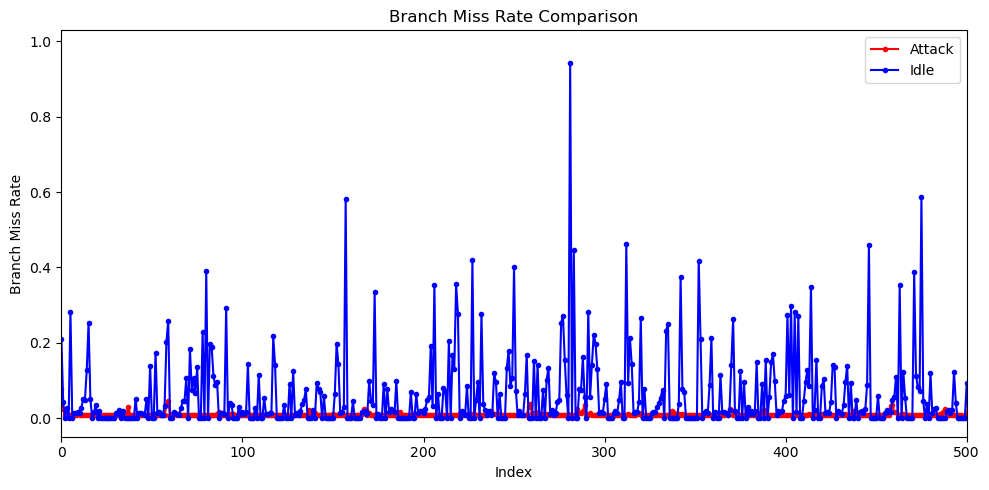

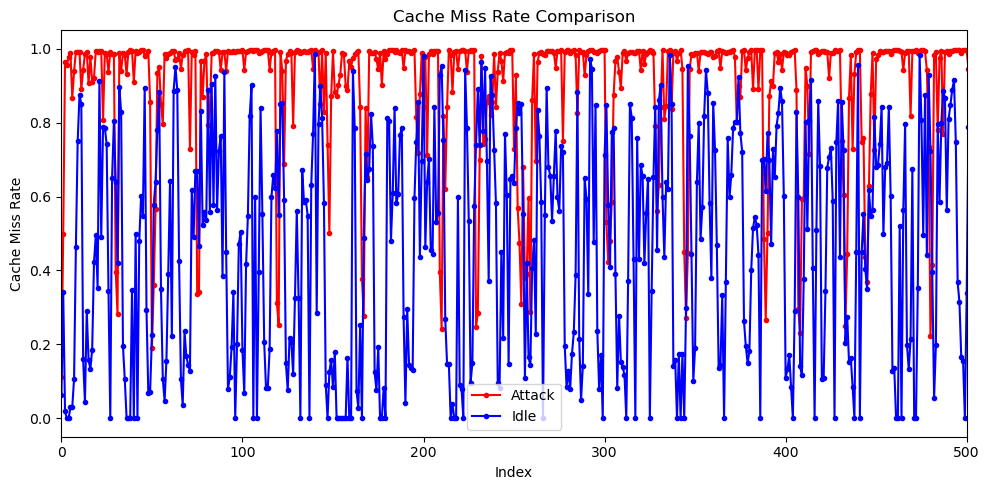

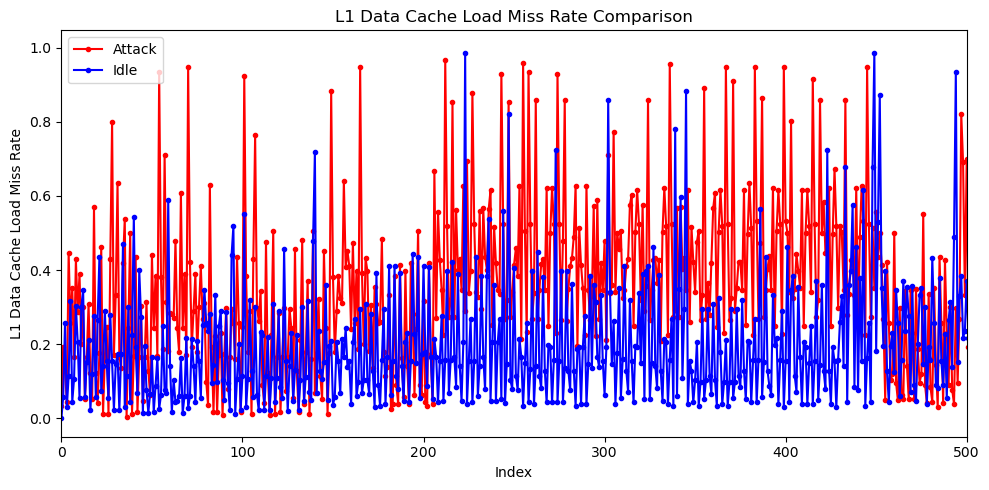

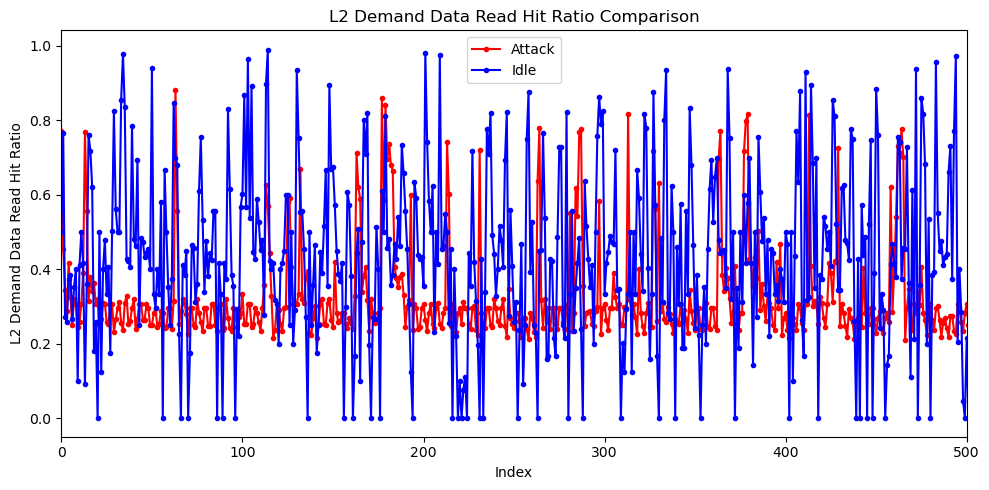

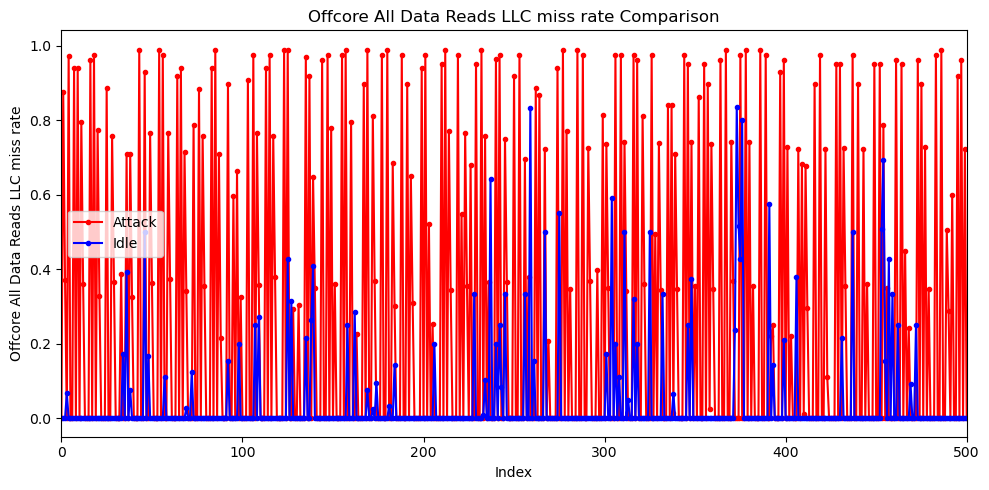

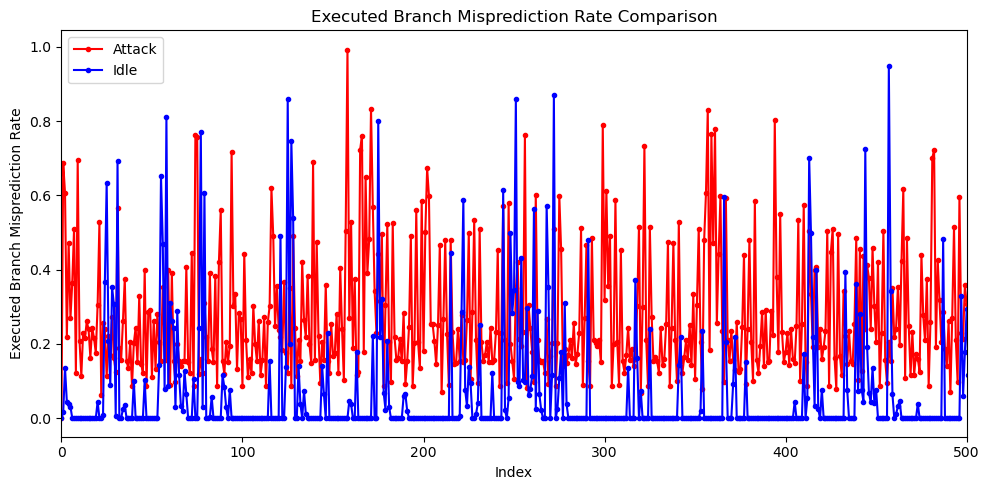

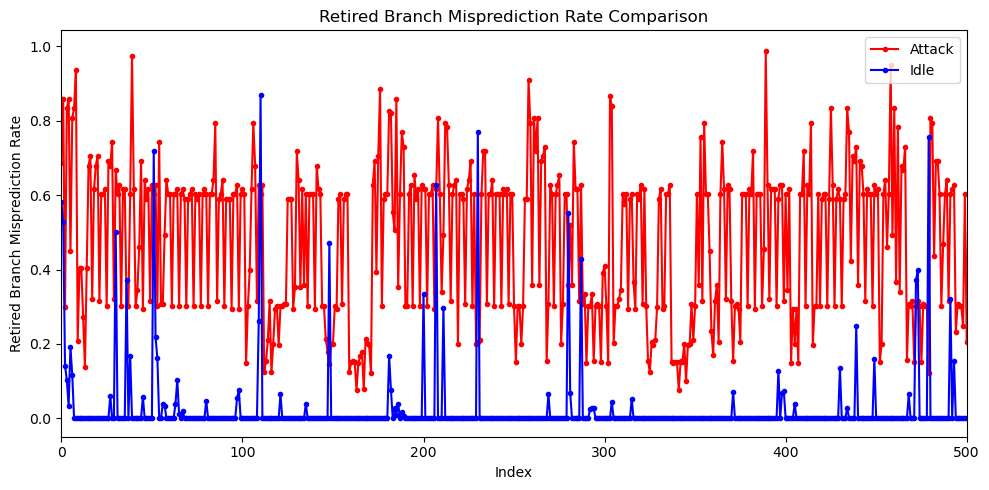

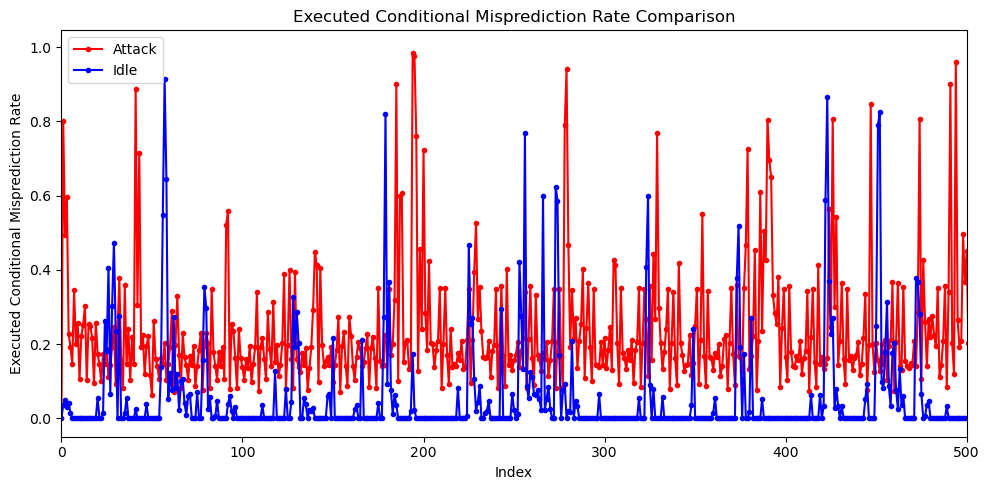

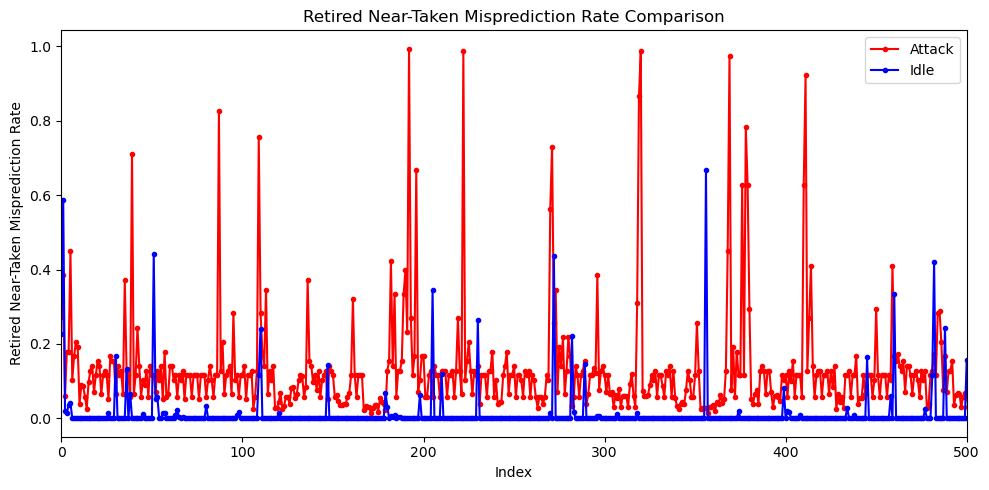

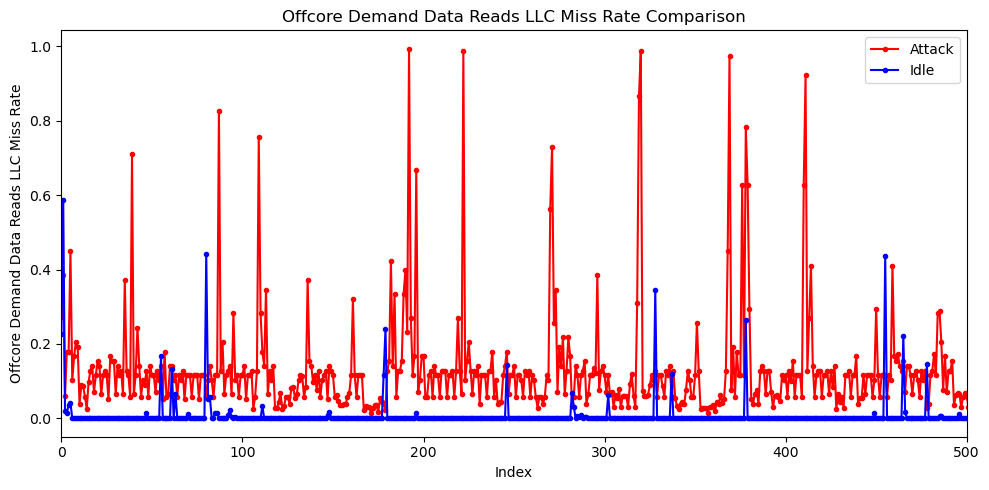

In [5]:
def split_into_column_dataframes(df):
    # Split into single-column DataFrames, dropping NA and 1.0, keeping values < 1
    return [df[[col]].dropna().loc[df[col] < 1].reset_index(drop=True) for col in df.columns]

def plot_column_dataframes(attack_column_dfs, idle_column_dfs):
    for attack_df, idle_df in zip(attack_column_dfs, idle_column_dfs):
        column_name = attack_df.columns[0]

        # Determine the max index for the current column's x-axis range
        max_index = 500

        fig, ax = plt.subplots(figsize=(10, 5))

        # Plot the attack data if available
        if not attack_df.empty:
            ax.plot(
                attack_df.index, attack_df[column_name].values,
                label='Attack', marker='.', linestyle='-', color='red'
            )

        # Plot the idle data if available
        if not idle_df.empty:
            ax.plot(
                idle_df.index, idle_df[column_name].values,
                label='Idle', marker='.', linestyle='-', color='blue'
            )

        ax.set_xlim([0, max_index])  # Set x-axis range based on the column's data
        ax.set_title(f'{column_name} Comparison')
        ax.set_xlabel('Index')
        ax.set_ylabel(column_name)
        ax.legend()
        plt.tight_layout()
        plt.show()

# Example usage:
attack_column_dfs = split_into_column_dataframes(attack_rate)
idle_column_dfs = split_into_column_dataframes(idle_rate)

plot_column_dataframes(attack_column_dfs, idle_column_dfs)


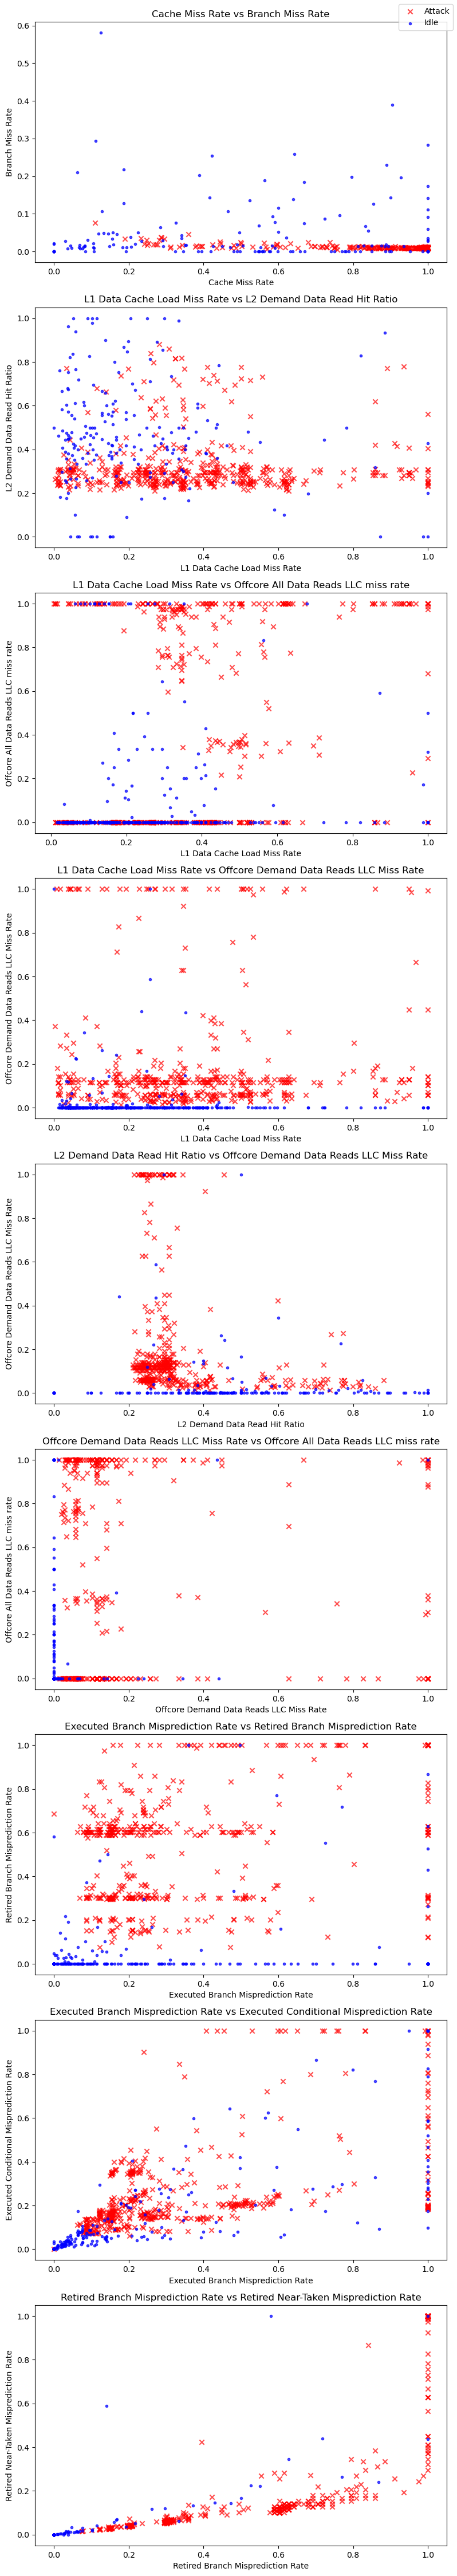

In [10]:
# Cell 5: Plot Cache vs Branch Metrics (Scatter Plots)
scatter_pairs = [
    (cache_miss_rate,branch_miss_rate),
    (L1_data_load_miss_rate, L2_demand_data_read_hit_rate),
    (L1_data_load_miss_rate,L3_all_data_read_miss_rate),
    (L1_data_load_miss_rate,L3_demand_data_read_miss_rate),
    (L2_demand_data_read_hit_rate,L3_demand_data_read_miss_rate),
    (L3_demand_data_read_miss_rate,L3_all_data_read_miss_rate),
    (executed_branch_misprediction_rate, retired_branch_misprediction_rate),
    (executed_branch_misprediction_rate, executed_conditional_misprediction_rate),
    (retired_branch_misprediction_rate, retired_near_taken_misprediction_rate)
]

fig, axes = plt.subplots(len(scatter_pairs), 1, figsize=(8, 5 * len(scatter_pairs)))
axes = axes.flatten()

plot_index = 0
attack_rate = attack_rate.iloc[:500]
idle_rate = idle_rate.iloc[:500]
for pair in scatter_pairs:   
    ax = axes[plot_index]
    ax.scatter(attack_rate[pair[0]], attack_rate[pair[1]], color='red', marker='x', label='Attack', alpha=0.7)
    ax.scatter(idle_rate[pair[0]], idle_rate[pair[1]], color='blue', marker='.', label='Idle', alpha=0.7)
    ax.set_title(f'{pair[0]} vs {pair[1]}')
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    plot_index += 1

fig.legend(['Attack', 'Idle'], loc='upper right')
plt.tight_layout()
plt.show()
